In [17]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.9 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [4]:
!pip install opencv-python

     |████████████████████████████████| 60.4 MB 48 kB/s s eta 0:00:01


In [18]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo

import cv2
import numpy as np

In [19]:
# class Detector:
#     def __init__(self):
#         self.cfg = get_cfg()
        
#         # Load model config and pretrained model
#         config_path = "./configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
#         #self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#         self.cfg.merge_from_file(config_path)
#         self.cfg.MODEL.WEIGHTS =  model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
        
#         self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
#         self.cfg.MODEL.DEVICE = "cuda" # cpu or cuda
        
#         self. predictor = DefaultPredictor(self.cfg)
    
#     def onImage(self, imagePath):
#         image = cv2.imread('../image/'+imagePath)
#         predictions = self.predictor(image)
        
#         viz = Visualizer(image[:,:,::-1], 
#                          metadata = MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]),
#             instance_mode = ColorMode.IMAGE_BW)
        
#         # Result goes same shape(size) on original image
#         output = viz.draw_instance_predictions(predictions["instances"].to("cpu"))
        
#         if cv2.imwrite("../result/pred_"+imagePath, output.get_image()[:,:,::-1]):
#             print("Successfully saved")
#         else:
#             print("Failed to save")
#         #cv2.imshow("Result", output.get_image()[:,:,::-1]) # imshow goes kernel die
#         cv2.waitKey(0)
        

In [20]:
# detector = Detector()
# detector.onImage('bears.jpg')

In [21]:
import random
import json
import os
from detectron2.structures import BoxMode
from detectron2.data.catalog import DatasetCatalog
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [22]:
def get_mask_dict(imgPath):
    json_file = os.path.join(imgPath, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
    if imgs_anns:
        print("")
        
    failed = []  
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        filename = os.path.join(imgPath, v["filename"])
        if not os.path.exists(filename):
            failed.append(v["filename"])
            continue
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file"] = v["filename"]
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        #for _, anno in annos.items():
        for anno in annos:
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts, failed


In [23]:
import copy
from detectron2.engine import DefaultTrainer
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # https://detectron2.readthedocs.io/en/latest/modules/data_transforms.html
    transform_list = [T.Resize((800,800)),
                      T.RandomBrightness(0.9, 1.1),
                      #T.ExtentTransform((100,100,700,700),(800,800)),
                      #T.RandomExtent((800,800),(100,100)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class LeafTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)


In [24]:
def register_dataset(df, datasetName='leaf', d="train"):
    dataset_path = "/workspace/dataset/"+datasetName+"_dataset/"
    
    DatasetCatalog.clear() # d: train or val
    DatasetCatalog.register(datasetName+"_" + d, lambda d=d: get_mask_dict(dataset_path + d)[0])
    MetadataCatalog.get(datasetName+"" + d).set(thing_classes=[datasetName])
    return MetadataCatalog.get(datasetName+"_"+d)


train_metadata = register_dataset('train')
val_metadata = register_dataset('val')
test_metadata = register_dataset('test')

In [25]:
from detectron2.data import build_detection_train_loader

cfg = get_cfg()
config_path = "./configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(config_path)
cfg.DATASETS.TRAIN = ("leaf_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = LeafTrainer(cfg) 

[02/15 17:16:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

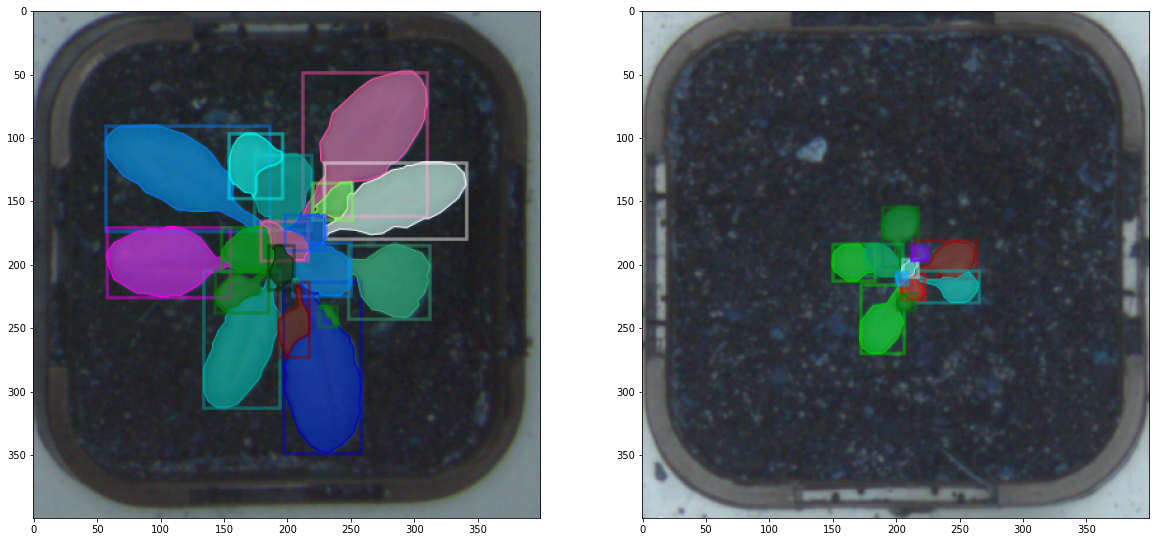

In [26]:
# Apply Augmentation
import matplotlib.pyplot as plt



train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

from IPython.display import clear_output
clear_output(wait=True)

rows, cols = 1, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:4]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])


In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

model_final_2d9806.pkl: 431MB [00:16, 26.9MB/s]                               
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due 

[02/15 17:17:28 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[02/15 17:18:14 d2.utils.events]:  eta: 3:02:24  iter: 19  total_loss: 5.539  loss_cls: 0.712  loss_box_reg: 0.795  loss_mask: 0.6911  loss_rpn_cls: 3.049  loss_rpn_loc: 0.3156  time: 2.1985  data_time: 0.0246  lr: 4.9953e-06  max_mem: 4683M
[02/15 17:18:59 d2.utils.events]:  eta: 3:04:05  iter: 39  total_loss: 4  loss_cls: 0.7066  loss_box_reg: 0.8788  loss_mask: 0.6812  loss_rpn_cls: 1.338  loss_rpn_loc: 0.2678  time: 2.2226  data_time: 0.0085  lr: 9.9902e-06  max_mem: 4683M
[02/15 17:19:44 d2.utils.events]:  eta: 3:03:36  iter: 59  total_loss: 2.813  loss_cls: 0.6305  loss_box_reg: 0.9125  loss_mask: 0.6631  loss_rpn_cls: 0.3423  loss_rpn_loc: 0.2208  time: 2.2257  data_time: 0.0110  lr: 1.4985e-05  max_mem: 4683M
[02/15 17:20:28 d2.utils.events]:  eta: 3:03:00  iter: 79  total_loss: 2.604  loss_cls: 0.557  loss_box_reg: 0.8756  loss_mask: 0.6345  loss_rpn_cls: 0.1128  loss_rpn_loc: 0.2391  time: 2.2280  data_time: 0.0100  lr: 1.998e-05  max_mem: 4683M
[02/15 17:21:13 d2.utils.event

In [23]:
# datasetName = "leaf"
# dataset_path = "/workspace/dataset/"+datasetName+"_dataset/"

# DatasetCatalog.clear()
# for d in ["train", "val"]:
#     DatasetCatalog.register(datasetName+"_" + d, lambda d=d: get_mask_dict(dataset_path + d)[0])
#     MetadataCatalog.get(datasetName+"" + d).set(thing_classes=[datasetName])
# leaf_metadata = MetadataCatalog.get(datasetName+"_train")

In [24]:
# import os
# dataset_dicts, failed = get_mask_dict(dataset_path+"train/")
# for d in random.sample(dataset_dicts, 3):
#     #print(d["file_name"])
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2.imwrite("/workspace/result/pred_"+d["file"], out.get_image()[:,:,::-1])

In [28]:
# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# config_path = "./configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
# cfg.merge_from_file(config_path)
# cfg.DATASETS.TRAIN = ("leaf_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[02/15 16:33:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/15 16:34:07 d2.engine.train_loop]: Starting training from iteration 0
[02/15 16:34:46 d2.utils.events]:  eta: 0:32:21  iter: 19  total_loss: 5.145  loss_cls: 0.6595  loss_box_reg: 0.743  loss_mask: 0.6948  loss_rpn_cls: 2.824  loss_rpn_loc: 0.2125  time: 1.9383  data_time: 0.0200  lr: 4.9953e-06  max_mem: 5331M
[02/15 16:35:24 d2.utils.events]:  eta: 0:31:37  iter: 39  total_loss: 3.621  loss_cls: 0.6304  loss_box_reg: 0.8808  loss_mask: 0.6859  loss_rpn_cls: 1.166  loss_rpn_loc: 0.2117  time: 1.9142  data_time: 0.0075  lr: 9.9902e-06  max_mem: 5331M
[02/15 16:36:02 d2.utils.events]:  eta: 0:30:41  iter: 59  total_loss: 2.869  loss_cls: 0.5976  loss_box_reg: 0.9137  loss_mask: 0.667  loss_rpn_cls: 0.4829  loss_rpn_loc: 0.2424  time: 1.9170  data_time: 0.0096  lr: 1.4985e-05  max_mem: 5331M
[02/15 16:36:39 d2.utils.events]:  eta: 0:29:58  iter: 79  total_loss: 2.368  loss_cls: 0.5469  loss_box_reg: 0.9071  loss_mask: 0.6402  loss_rpn_cls: 0.08705  loss_rpn_loc: 0.1363  time: 1.9045 

KeyboardInterrupt: 

In [ ]:
cfg = get_cfg()
config_path = "./configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = WEIGHT_PATH
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.DATASETS.TEST = ('leaf_test', )
predictor = DefaultPredictor(cfg)

In [ ]:
cfg = get_cfg()
config_path = "./configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = "/workspace/detectron2/output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.DATASETS.TEST = ('leaf_test', )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts, failed = get_mask_dict(dataset_path+"test/")
for d in random.sample(dataset_dicts, 6):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# evaluator = COCOEvaluator(val_dataset, cfg, False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, val_dataset)
# inference_on_dataset(trainer.model, val_loader, evaluator)
